
    This Source Code Form is subject to the terms of the Mozilla Public
    License, v. 2.0. If a copy of the MPL was not distributed with this
    file, You can obtain one at http://mozilla.org/MPL/2.0/.


In [1]:
# Enable automatic module reload
%load_ext autoreload
%autoreload 2

# To ease the loading of modules
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# Load BEACS module
from beacs.agents.beacs import BEACS, Configuration

# Load Metrics
from example.metrics.MazeMetrics import \
    _maze_metrics, \
    _how_many_peps_match_non_aliased_states, \
    _mean_reliable_classifier_specificity, \
    _when_full_knowledge_is_achieved, \
    _enhanced_effect_error

# Load Plotting Wrappers
from example.metrics.MazePlottingWrapper import \
    parse_metrics_to_df, \
    plot_performance

# Load environments
import gym
import my_mazes

# Agent - BEACS

## Common parameters

In [2]:
#Environmental Set Up
RANDOM_ATTRIBUTE_LENGTH = 0
CLASSIFIER_LENGTH = 8 + RANDOM_ATTRIBUTE_LENGTH
NUMBER_OF_POSSIBLE_ACTIONS = 8
SLIPPERY_PROB = 0.25
MAZE = "Maze7-v0"

#Exploration Set Up
NUMBER_OF_EXPLORE_TRIALS = 5000
METRICS_TRIAL_FREQUENCY_EXPLORE = 100
EPSILON = 0.8

#Exploitation Set Up
NUMBER_OF_EXPLOIT_TRIALS_NO_RL = 500
BETA_EXPLOIT_NO_RL = 0.00
NUMBER_OF_EXPLOIT_TRIALS_RL_START = 500
BETA_EXPLOIT_RL_START = 0.05
NUMBER_OF_EXPLOIT_TRIALS_RL = 500
BETA_EXPLOIT_RL = 0.05

#RL Set Up
GAMMA = 0.95
BETA_RL = 0.05

#BEACS Set Up
DO_ZIP = True
DO_GA = True
ENABLE_PEP = True
LENGTH_OF_BEHAVIORAL_SEQUENCES = 2
BETA_ALP = 0.05

## Environment - Maze

In [3]:
# Initialize environment
maze = gym.make(MAZE)
# Set up probability to do a random action
maze.env.set_prob_slippery(SLIPPERY_PROB)
# Set up random attribute length
maze.env.set_random_attribute_length(RANDOM_ATTRIBUTE_LENGTH)
# Reset it, by putting an agent into random position
maze.reset()
# Render the state in ASCII
maze.render('aliasing_human')
# Get environmental state transitions
#maze.env.get_theoritical_probabilities()


■ ■ ■ ■ ■
■ □ A □ ■
■ □ ■ □ ■
■ ■ ■ ■ ■
■ □ ■ □ ■
■ $ ■ ■ ■
■ ■ ■ ■ ■


## Training of BEACS - Exploration

In [4]:
%%time

cfg_explore = Configuration(
    classifier_length=CLASSIFIER_LENGTH,
    number_of_possible_actions=NUMBER_OF_POSSIBLE_ACTIONS,
    user_metrics_collector_fcn=_maze_metrics,
    metrics_trial_frequency=METRICS_TRIAL_FREQUENCY_EXPLORE,
    do_pep=ENABLE_PEP,
    do_ga=DO_GA,
    beta_alp=BETA_ALP,
    beta_rl=BETA_RL,
    gamma=GAMMA,
    theta_i=0.1,
    theta_r=0.9,
    epsilon=EPSILON,
    u_max=CLASSIFIER_LENGTH,
    theta_exp=20,
    theta_ga=100,
    theta_bseq=1000,
    theta_as=20,
    mu=0.3,
    chi=0.8,
    bs_max=LENGTH_OF_BEHAVIORAL_SEQUENCES
)

agent_explore = BEACS(cfg_explore)
population_explore, metrics_explore = agent_explore.explore(maze, NUMBER_OF_EXPLORE_TRIALS)

CPU times: user 11min 52s, sys: 7.94 s, total: 12min
Wall time: 12min 27s


### Performance

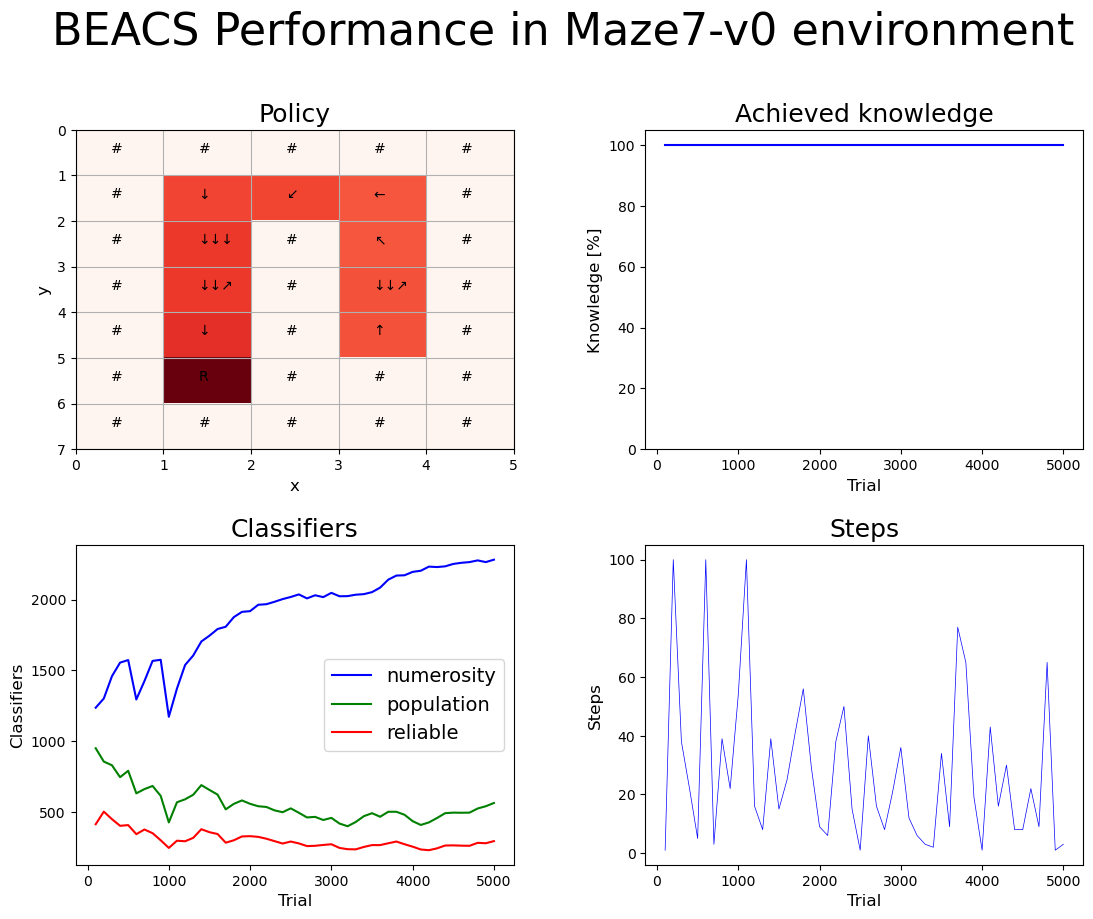

In [5]:
metrics_trial_frequency_explore = cfg_explore.metrics_trial_frequency

metrics_df = parse_metrics_to_df(metrics_explore, metrics_trial_frequency_explore, None, None)
plot_performance(agent_explore, maze, metrics_df, cfg_explore, MAZE, metrics_trial_frequency_explore, None)

In [6]:
first_trial, stable_trial, last_trial = _when_full_knowledge_is_achieved(metrics_explore)
print("Full knowledge was achieved at trials ", first_trial, ", was stable at ", stable_trial, 
        " and the last time it was achieved at ", last_trial)

print("There are ", _how_many_peps_match_non_aliased_states(population_explore, maze),
      " enhanced classifer(s) that match a non-aliased states.\n")

print(_maze_metrics(population_explore, maze))
print("Mean reliable population specifity is ",
      _mean_reliable_classifier_specificity(population_explore, maze))
pep_error = _enhanced_effect_error(population_explore, maze, CLASSIFIER_LENGTH, RANDOM_ATTRIBUTE_LENGTH)
print("Accumulated Error on PEP Probabilities :", pep_error, "%\n")

if DO_ZIP:
    agent_explore.zip_population()
    population_explore = agent_explore.get_population()

print(_maze_metrics(population_explore, maze))
print("Mean reliable population specifity is ",
      _mean_reliable_classifier_specificity(population_explore, maze))
pep_error = _enhanced_effect_error(population_explore, maze, CLASSIFIER_LENGTH, RANDOM_ATTRIBUTE_LENGTH)
print("Accumulated Error on PEP Probabilities :", pep_error, "%")

Full knowledge was achieved at trials  100 , was stable at  100  and the last time it was achieved at  5000
There are  190  enhanced classifer(s) that match a non-aliased states.

{'knowledge': 100.0, 'population': 565, 'numerosity': 2281, 'reliable': 296}
Mean reliable population specifity is  0.7863175675675675
Accumulated Error on PEP Probabilities : 1.2591526714699894 %

{'knowledge': 100.0, 'population': 219, 'numerosity': 1770, 'reliable': 139}
Mean reliable population specifity is  0.7230215827338129
Accumulated Error on PEP Probabilities : 1.2835659110568882 %


In [7]:
population_explore.sort(key=lambda cl: -cl.fitness)
population_explore_to_display = [cl for cl in population_explore]
for cl in population_explore_to_display:
    print(cl)
    print("\n")

#1##9### 4 None (########:#365, ####1###:#1512, ####0###:#67) (empty)
q: 1.0    ra: 990.1  rb: 987.2  ir: 868.2  f: 990.1  err: 18.89 
exp: 1931  num: 17 ee: False PAI_state: 
tga: 179016 tbseq: 178633 talp: 179070 tav: 92.26  



#1##9### 4 [4, 4] (########:#5, ####1###:#154) (empty)
q: 1.0    ra: 975.2  rb: 989.7  ir: 999.5  f: 975.2  err: 33.24 
exp: 158   num: 20 ee: False PAI_state: 01110111
tga: 178931 tbseq: 86266 talp: 178931 tav: 835.8  



0011011# 4 [4, 4] (#1##9###:#568, #1##1###:#854, #1######:#215, 1100100#:#61, ########:#17) (00110111)
q: 1.0    ra: 948.9  rb: 959.7  ir: 597.8  f: 948.9  err: 52.72 
exp: 521   num: 2 ee: True PAI_state: 01110111
tga: 179018 tbseq: 138841 talp: 179018 tav: 51.64  



01##9### 4 [4] (########:#15, ####1###:#165) (01119111)
q: 0.9593 ra: 989.8  rb: 980.1  ir: 914.0  f: 944.9  err: 29.34 
exp: 180   num: 18 ee: True PAI_state: 01110111
tga: 178604 tbseq: 76043 talp: 178604 tav: 560.8  



0#1#9#1# 6 None (########:#359, ####0###:#13, ####1##

In [8]:
agent_explore.get_pai_states_memory()

[('0', '1', '1', '1', '0', '1', '1', '1')]

## Training of BEACS - Exploitation

In [9]:
%%time

cfg_exploit_no_rl = Configuration(
    classifier_length=CLASSIFIER_LENGTH,
    number_of_possible_actions=NUMBER_OF_POSSIBLE_ACTIONS,
    user_metrics_collector_fcn=_maze_metrics,
    metrics_trial_frequency=1,
    do_pep=ENABLE_PEP,
    do_ga=False,
    beta_alp=BETA_ALP,
    beta_rl=BETA_EXPLOIT_NO_RL,
    gamma=GAMMA,
    theta_i=0.1,
    theta_r=0.9,
    epsilon=0.0,
    u_max=CLASSIFIER_LENGTH,
    theta_exp=20,
    theta_ga=100,
    theta_bseq=1000,
    theta_as=20,
    mu=0.3,
    chi=0.8,
    bs_max=LENGTH_OF_BEHAVIORAL_SEQUENCES
)

agent_exploit_no_rl = BEACS(cfg_exploit_no_rl, population_explore)
population_exploit_no_rl, metrics_exploit_no_rl = agent_exploit_no_rl.exploit(maze, NUMBER_OF_EXPLOIT_TRIALS_NO_RL)

CPU times: user 8.06 s, sys: 111 ms, total: 8.17 s
Wall time: 8.67 s


In [10]:
%%time

cfg_exploit_rl_start = Configuration(
    classifier_length=CLASSIFIER_LENGTH,
    number_of_possible_actions=NUMBER_OF_POSSIBLE_ACTIONS,
    user_metrics_collector_fcn=_maze_metrics,
    metrics_trial_frequency=1,
    do_pep=ENABLE_PEP,
    do_ga=False,
    beta_alp=BETA_ALP,
    beta_rl=BETA_EXPLOIT_RL_START,
    gamma=GAMMA,
    theta_i=0.1,
    theta_r=0.9,
    epsilon=0.0,
    u_max=CLASSIFIER_LENGTH,
    theta_exp=20,
    theta_ga=100,
    theta_bseq=1000,
    theta_as=20,
    mu=0.3,
    chi=0.8,
    bs_max=LENGTH_OF_BEHAVIORAL_SEQUENCES
)

agent_exploit_rl_start = BEACS(cfg_exploit_rl_start, population_exploit_no_rl)
population_exploit_rl_start, metrics_exploit_rl_start = agent_exploit_rl_start.exploit(maze, NUMBER_OF_EXPLOIT_TRIALS_RL_START)

CPU times: user 4.81 s, sys: 60.6 ms, total: 4.87 s
Wall time: 5.08 s


In [11]:
%%time

cfg_exploit_rl = Configuration(
    classifier_length=CLASSIFIER_LENGTH,
    number_of_possible_actions=NUMBER_OF_POSSIBLE_ACTIONS,
    user_metrics_collector_fcn=_maze_metrics,
    metrics_trial_frequency=1,
    do_pep=ENABLE_PEP,
    do_ga=False,
    beta_alp=BETA_ALP,
    beta_rl=BETA_EXPLOIT_RL,
    gamma=GAMMA,
    theta_i=0.1,
    theta_r=0.9,
    epsilon=0.0,
    u_max=CLASSIFIER_LENGTH,
    theta_exp=20,
    theta_ga=100,
    theta_bseq=1000,
    theta_as=20,
    mu=0.3,
    chi=0.8,
    bs_max=LENGTH_OF_BEHAVIORAL_SEQUENCES
)

agent_exploit_rl = BEACS(cfg_exploit_rl, population_exploit_rl_start)
population_exploit_rl, metrics_exploit_rl = agent_exploit_rl.exploit(maze, NUMBER_OF_EXPLOIT_TRIALS_RL)

CPU times: user 4.62 s, sys: 44.5 ms, total: 4.67 s
Wall time: 4.75 s


### Performance

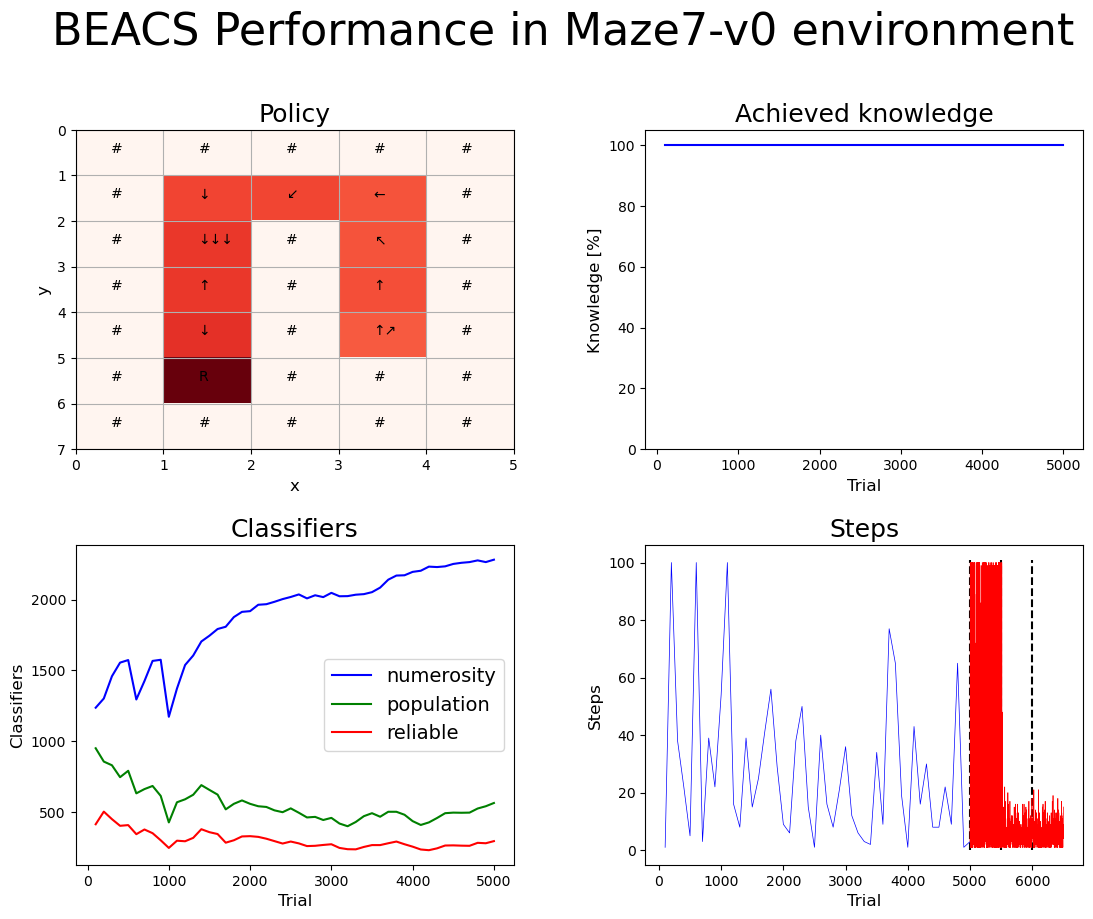

In [12]:
metrics_trial_frequency_explore = cfg_explore.metrics_trial_frequency
metrics_trial_frequency_exploit = 1

metrics_exploit = metrics_exploit_no_rl.copy()
for idx, item in enumerate(metrics_exploit_rl_start):
    tmp = item.copy()
    tmp['trial'] += NUMBER_OF_EXPLOIT_TRIALS_NO_RL
    metrics_exploit.append(tmp)
for idx, item in enumerate(metrics_exploit_rl):
    tmp = item.copy()
    tmp['trial'] += NUMBER_OF_EXPLOIT_TRIALS_NO_RL + NUMBER_OF_EXPLOIT_TRIALS_RL_START
    metrics_exploit.append(tmp)

metrics_df = parse_metrics_to_df(metrics_explore, metrics_trial_frequency_explore, metrics_exploit, metrics_trial_frequency_exploit)
plot_performance(agent_exploit_rl, maze, metrics_df, cfg_exploit_rl, MAZE, metrics_trial_frequency_explore, [NUMBER_OF_EXPLOIT_TRIALS_NO_RL,NUMBER_OF_EXPLOIT_TRIALS_RL_START,NUMBER_OF_EXPLOIT_TRIALS_RL])

In [13]:
avg_step_explore = 0
for trial in metrics_explore:
    avg_step_explore += trial['steps_in_trial']
avg_step_explore /= NUMBER_OF_EXPLORE_TRIALS / metrics_trial_frequency_explore
print("Average number of steps to solve the maze is ",avg_step_explore,
      " for a total of ", NUMBER_OF_EXPLORE_TRIALS, " trials in EXPLORATION")

avg_step_exploit_no_rl = 0
for trial in metrics_exploit_no_rl:
    avg_step_exploit_no_rl += trial['steps_in_trial']
avg_step_exploit_no_rl /= NUMBER_OF_EXPLOIT_TRIALS_NO_RL
print("Average number of steps to solve the maze is ",avg_step_exploit_no_rl,
      " for a total of ", NUMBER_OF_EXPLOIT_TRIALS_NO_RL, " trials in EXPLOITATION without Reinforcement Module")

avg_step_exploit_rl_start = 0
for trial in metrics_exploit_rl_start:
    avg_step_exploit_rl_start += trial['steps_in_trial']
avg_step_exploit_rl_start /= NUMBER_OF_EXPLOIT_TRIALS_RL_START
print("Average number of steps to solve the maze is ",avg_step_exploit_rl_start,
      " for a total of ", NUMBER_OF_EXPLOIT_TRIALS_RL_START, " trials in EXPLOITATION starting Reinforcement Module")

avg_step_exploit_rl = 0
for trial in metrics_exploit_rl:
    avg_step_exploit_rl += trial['steps_in_trial']
avg_step_exploit_rl /= NUMBER_OF_EXPLOIT_TRIALS_RL
print("Average number of steps to solve the maze is ",avg_step_exploit_rl,
      " for a total of ", NUMBER_OF_EXPLOIT_TRIALS_RL, " trials in EXPLOITATION with Reinforcement Module")

print(_maze_metrics(population_explore, maze))
print(_maze_metrics(population_exploit_no_rl, maze))
print(_maze_metrics(population_exploit_rl_start, maze))
print(_maze_metrics(population_exploit_rl, maze))

Average number of steps to solve the maze is  27.72  for a total of  5000  trials in EXPLORATION
Average number of steps to solve the maze is  22.648  for a total of  500  trials in EXPLOITATION without Reinforcement Module
Average number of steps to solve the maze is  5.912  for a total of  500  trials in EXPLOITATION starting Reinforcement Module
Average number of steps to solve the maze is  5.72  for a total of  500  trials in EXPLOITATION with Reinforcement Module
{'knowledge': 100.0, 'population': 219, 'numerosity': 1770, 'reliable': 139}
{'knowledge': 100.0, 'population': 219, 'numerosity': 1770, 'reliable': 139}
{'knowledge': 100.0, 'population': 219, 'numerosity': 1770, 'reliable': 139}
{'knowledge': 100.0, 'population': 219, 'numerosity': 1770, 'reliable': 139}


In [14]:
population_exploit_rl.sort(key=lambda cl: -cl.q)
population_exploit_rl_to_display = [cl for cl in population_exploit_rl
    if (cl.behavioral_sequence is None)]
print(len(population_exploit_rl_to_display))
print("\n")
for cl in population_exploit_rl_to_display:
    print(cl)
    print("\n")

168


#1##9### 4 None (########:#365, ####1###:#1512, ####0###:#67) (empty)
q: 1.0    ra: 979.2  rb: 985.1  ir: 844.9  f: 985.1  err: 27.68 
exp: 1931  num: 17 ee: False PAI_state: 
tga: 179016 tbseq: 178633 talp: 179070 tav: 92.26  



01#19##1 2 None (########:#633, ####1###:#18, ####0###:#20) (empty)
q: 1.0    ra: 931.1  rb: 935.7  ir: 41.04  f: 935.7  err: 17.31 
exp: 525   num: 12 ee: False PAI_state: 
tga: 178931 tbseq: 178633 talp: 178931 tav: 201.3  



11010##1 4 None (########:#63, 001#####:#208) (empty)
q: 1.0    ra: 892.3  rb: 882.4  ir: 0.0    f: 892.3  err: 22.97 
exp: 82    num: 2 ee: False PAI_state: 
tga: 179039 tbseq: 178905 talp: 179039 tav: 44.3   



0011011# 3 None (########:#418, 110#####:#15, 1100100#:#14, #1######:#13) (empty)
q: 1.0    ra: 871.9  rb: 892.3  ir: 0.0    f: 892.3  err: 24.23 
exp: 358   num: 19 ee: False PAI_state: 
tga: 178702 tbseq: 178420 talp: 178702 tav: 366.9  



1#001001 5 None (0011011#:#2941, ########:#448, ##1101##:#110, 0#110110:#105,




1101##1# 6 None (########:#1) (11010111)
q: 0.8752 ra: 838.8  rb: 836.7  ir: 0.0    f: 734.1  err: 9.895 
exp: 50    num: 1 ee: True PAI_state: 
tga: 178679 tbseq: 178905 talp: 178723 tav: 35.98  



#1##9### 7 None (########:#1) (empty)
q: 0.8463 ra: 937.4  rb: 926.9  ir: 9.752  f: 793.3  err: 5.04  
exp: 24    num: 2 ee: False PAI_state: 
tga: 179069 tbseq: 178633 talp: 179069 tav: 426.0  



110#0### 4 None (001#####:#1) (11010111)
q: 0.8365 ra: 887.3  rb: 888.8  ir: 0.0    f: 743.5  err: 23.03 
exp: 70    num: 1 ee: True PAI_state: 
tga: 179039 tbseq: 178905 talp: 179039 tav: 44.03  



#1110#11 7 None (########:#1) (empty)
q: 0.8268 ra: 793.0  rb: 793.7  ir: 0.0    f: 656.2  err: 8.288 
exp: 9     num: 1 ee: False PAI_state: 
tga: 179024 tbseq: 178191 talp: 179024 tav: 260.1  



0###9#1# 6 None (########:#1) (01119111)
q: 0.8265 ra: 941.9  rb: 938.9  ir: 54.6   f: 778.5  err: 2.637 
exp: 24    num: 1 ee: True PAI_state: 
tga: 178988 tbseq: 178633 talp: 179027 tav: 276.3  



1